In [1]:
#Imports

#Basic Imports
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import zipfile

#Plotting
import seaborn as sns
%matplotlib inline
sns.set_style('white')

#Models
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression, RidgeClassifier
import statsmodels.api as sm


#Data Infrastructure Pieces
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
from sklearn.model_selection import cross_val_score

In [2]:
zf = zipfile.ZipFile("student.zip")
df = pd.read_csv(zf.open('student-mat.csv'),sep = ";")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
school        395 non-null object
sex           395 non-null object
age           395 non-null int64
address       395 non-null object
famsize       395 non-null object
Pstatus       395 non-null object
Medu          395 non-null int64
Fedu          395 non-null int64
Mjob          395 non-null object
Fjob          395 non-null object
reason        395 non-null object
guardian      395 non-null object
traveltime    395 non-null int64
studytime     395 non-null int64
failures      395 non-null int64
schoolsup     395 non-null object
famsup        395 non-null object
paid          395 non-null object
activities    395 non-null object
nursery       395 non-null object
higher        395 non-null object
internet      395 non-null object
romantic      395 non-null object
famrel        395 non-null int64
freetime      395 non-null int64
goout         395 non-null int64
Dalc          395 no

In [3]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [4]:
df_dumb = pd.get_dummies(df[['sex', 'higher', 'famsup']],drop_first=True)
df_dumb.head()
df_newc = pd.concat([df_dumb,df[['age', 'studytime', 'Medu']]], axis=1)

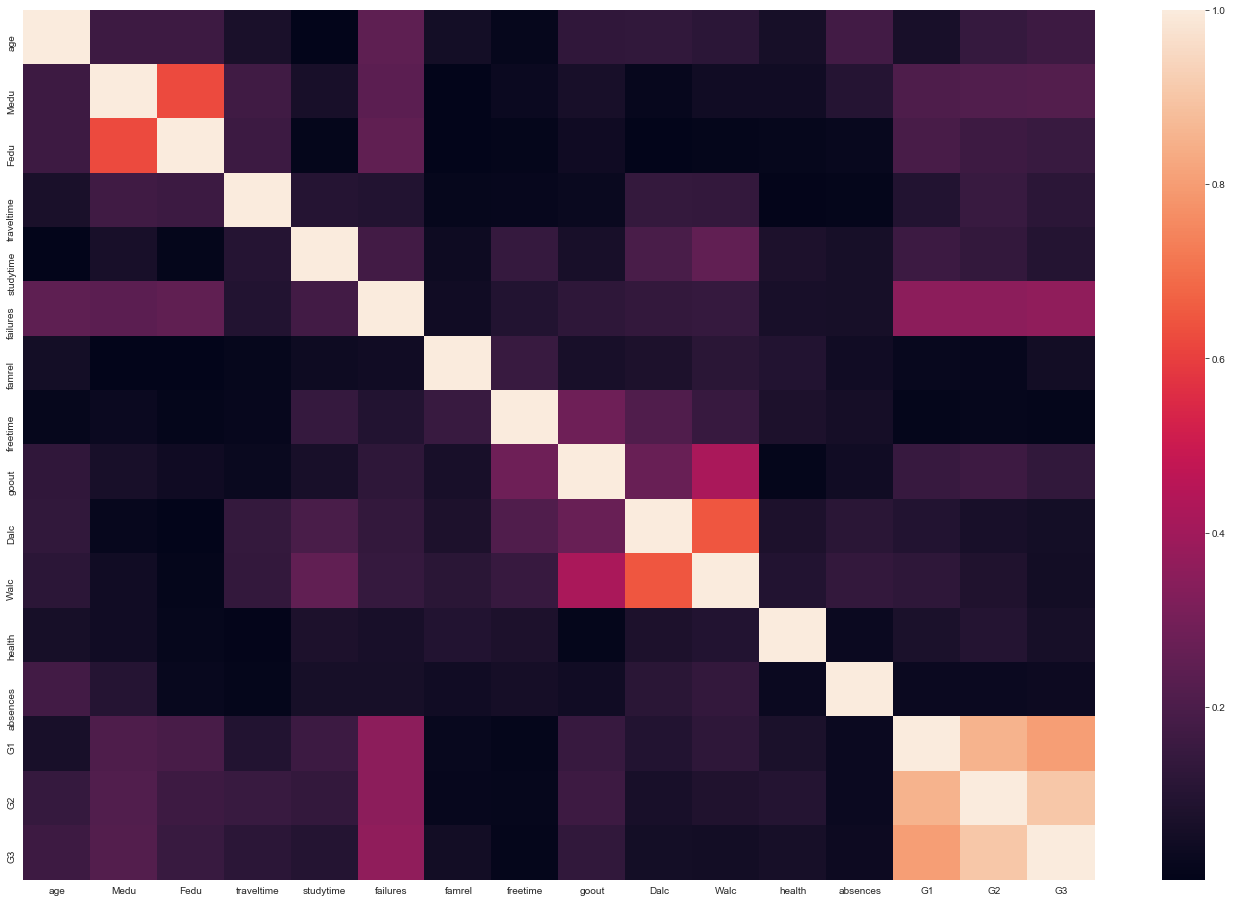

In [5]:
fig, ax = plt.subplots()
fig.set_size_inches(24, 16)
sns.heatmap(df.corr().abs())

Heatmap based on new dataset

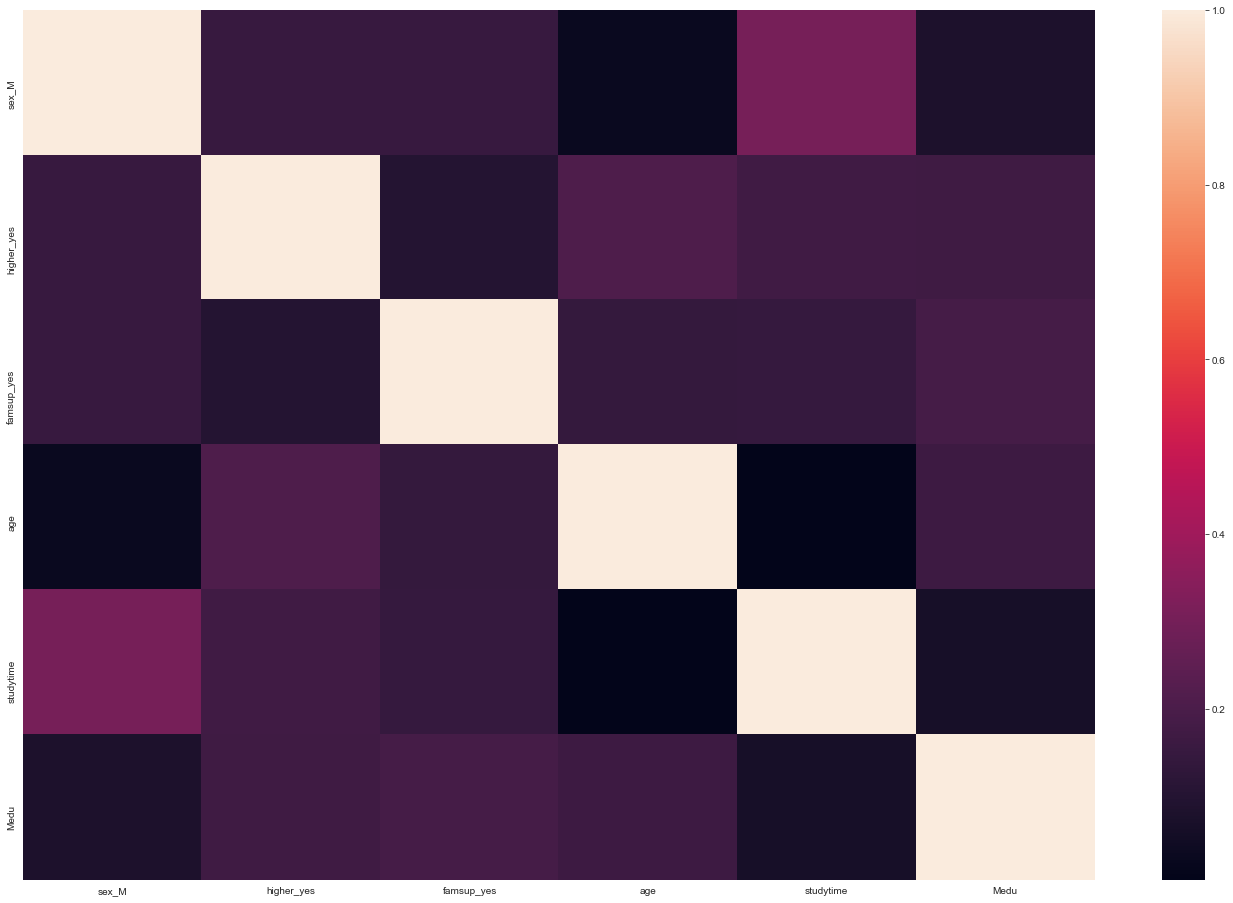

In [6]:
fig, ax = plt.subplots()
fig.set_size_inches(24, 16)
sns.heatmap(df_newc.corr().abs())

## Models

### Test Train Split

In [7]:
X = df_newc.drop('higher_yes', axis = 1)
Y = df_newc[['higher_yes']]

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, stratify=Y, test_size=0.25)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(296, 5) (296, 1)
(99, 5) (99, 1)


### Vanilla Logistic Regression

In [8]:
# Declare predictors.
X_statsmod = X_train.copy()

# The Statsmodels formulation requires a column with constant value 1 that
# will act as the intercept.
#X_statsmod['intercept'] = 1 

# Declare and fit the model.
logit = sm.Logit(Y_train, X_statsmod)
result = logit.fit(maxiter=1000)

# Lots of information about the model and its coefficients, but the
# accuracy rate for predictions is missing.
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.048958
         Iterations 9
                        Results: Logit
Model:              Logit            Pseudo R-squared: inf    
Dependent Variable: higher_yes       AIC:              38.9833
Date:               2019-04-27 09:21 BIC:              57.4351
No. Observations:   296              Log-Likelihood:   -14.492
Df Model:           4                LL-Null:          0.0000 
Df Residuals:       291              LLR p-value:      1.0000 
Converged:          1.0000           Scale:            1.0000 
No. Iterations:     9.0000                                    
---------------------------------------------------------------
             Coef.   Std.Err.     z     P>|z|    [0.025  0.975]
---------------------------------------------------------------
sex_M       -0.4965    0.6463  -0.7682  0.4424  -1.7632  0.7702
famsup_yes   0.0372    0.5717   0.0651  0.9481  -1.0833  1.1578
age         -0.0887    0.0638  -1.3

C:\Users\postgres\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\postgres\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\postgres\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:3313: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


In [9]:
df_newc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 6 columns):
sex_M         395 non-null uint8
higher_yes    395 non-null uint8
famsup_yes    395 non-null uint8
age           395 non-null int64
studytime     395 non-null int64
Medu          395 non-null int64
dtypes: int64(3), uint8(3)
memory usage: 10.5 KB


In [24]:
# Calculate accuracy. First, get probability that each row will be admitted.
pred_statsmod = result.predict(X_test)

# Code admission as 1 if probability is greater than .5.
pred_Y_statsmod = np.where(pred_statsmod < .8, 0, 1)
pred_Y_statsmod = np.expand_dims(pred_Y_statsmod, axis=1)



In [25]:
confusion_matrix(pred_Y_statsmod, Y_test)

array([[ 2,  9],
       [ 3, 85]], dtype=int64)

### Ridge Logistic Regression

In [63]:
ridgemodel = RidgeClassifier(alpha=1.0, class_weight='balanced')
# alpha is default of 1.0 for ridge classifier things changed with balancing the weight class. Encompasses all variables in the entire picture.
ridgemodel.fit(X_train, Y_train)
y_pred=ridgemodel.predict(X_test)
ridgemodel.score(X_test, Y_test)

C:\Users\postgres\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:839: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7171717171717171

In [64]:
print(y_pred)

[0 1 1 0 1 1 0 0 1 1 1 1 1 0 1 0 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1
 1 1 0 0 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 0 1 1 1 1 1 0 1
 0 1 1 1 0 1 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 1 1 1 0]


In [65]:
confusion_matrix(y_pred, Y_test)

array([[ 4, 27],
       [ 1, 67]], dtype=int64)

### Cross Validation Score

In [66]:
print(cross_val_score(ridgemodel, X_train, Y_train, cv=5))

[0.78333333 0.74576271 0.79661017 0.74576271 0.81355932]


C:\Users\postgres\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:839: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\postgres\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:839: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\postgres\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:839: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\postgres\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:839: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

In [67]:
crs1 = cross_val_score(ridgemodel, X_train, Y_train, cv=5)

C:\Users\postgres\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:839: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\postgres\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:839: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\postgres\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:839: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\postgres\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:839: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

In [68]:
np.mean(crs1)

0.7770056497175142

## Lasso Regression

In [69]:
lassoR = LogisticRegression(C=.8, penalty='l1', class_weight='balanced', solver = 'liblinear')
# notes for Lasso regression is lassoing the upper coefficients(Above 0) and dropping the lower coefficients(0 and below)  
lassoR.fit(X_train, Y_train)
y_pred=lassoR.predict(X_test)
lassoR.score(X_test, Y_test)

C:\Users\postgres\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\postgres\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.7171717171717171

In [70]:
print(y_pred)

[0 1 1 0 1 1 0 0 1 1 1 1 1 0 1 0 1 1 0 0 0 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1
 1 1 0 0 1 1 1 0 0 1 0 0 1 1 1 1 0 1 1 1 1 0 1 1 0 0 0 1 1 0 1 1 1 1 1 1 1
 0 1 1 1 1 1 0 1 1 0 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1]


In [71]:
confusion_matrix(y_pred, Y_test)

array([[ 4, 27],
       [ 1, 67]], dtype=int64)

### Cross Validation

In [72]:
print(cross_val_score(lassoR, X_train, Y_train, cv=5))

[0.78333333 0.79661017 0.79661017 0.74576271 0.76271186]


C:\Users\postgres\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\postgres\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\postgres\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\postgres\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\postgres\Anaconda3\lib\site-packages\skle

In [73]:
crs = cross_val_score(lassoR, X_train, Y_train, cv=5)

C:\Users\postgres\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\postgres\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\postgres\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\postgres\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\postgres\Anaconda3\lib\site-packages\skle

In [74]:
np.mean(crs)

0.7770056497175141